Beginning of our project :)

Reading our Dataset Below:

In [68]:
#import sklearn.datasets
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import spacy
from pprint import pprint

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score # better metric due to small frequence of date for few types
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

In [ ]:
MB_dataset = pd.read_csv('mbti_1.csv')
print(MB_dataset)
MB_dataset.describe()


In [ ]:
personalities = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}
MB_dataset.head()

In [39]:
cnt = MB_dataset.groupby(['type'])['posts'].count()
pie = go.Pie(labels=cnt.index, values=cnt.values)
fig = go.Figure(data=[pie])
py.iplot(fig)

In [43]:
def replace_symbols(text):
    text = re.sub('\|\|\|', ' ', text)
    text = re.sub('https?\S+', '<URL>', text)
    return text

MB_dataset['cleaned_posts'] = MB_dataset['posts'].apply(replace_symbols)

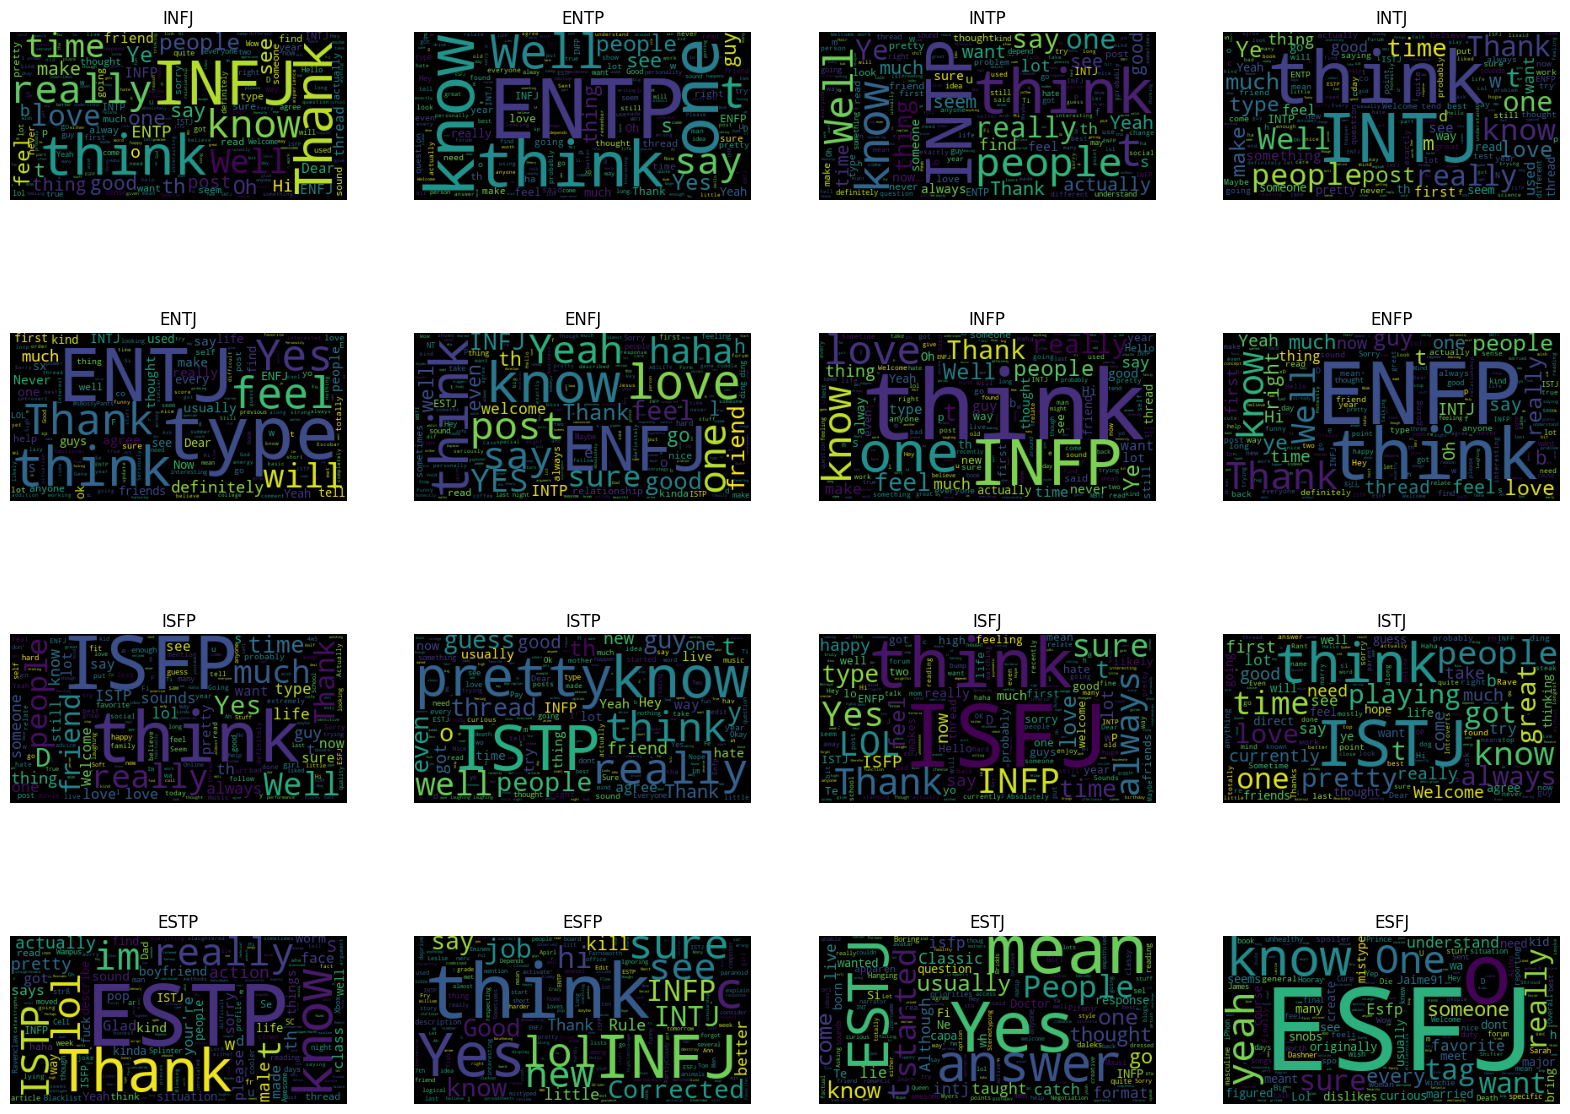

In [47]:
STOPWORDS.add('URL') # words to not consider
labels = MB_dataset['type'].unique()
row, col = 4, 4
wc = WordCloud(stopwords=STOPWORDS)

fig, ax = plt.subplots(4, 4, figsize=(20,15))

for i in range(4):
    for j in range(4):
        cur_type = labels[i*col+j]
        cur_ax = ax[i][j]
        df = MB_dataset[MB_dataset['type'] == cur_type]
        wordcloud = wc.generate(df['cleaned_posts'].to_string())
        cur_ax.imshow(wordcloud)
        cur_ax.axis('off')
        cur_ax.set_title(cur_type)

In [50]:
type_enc = LabelEncoder()
type_enc.fit(MB_dataset['type'])
type_enc.classes_

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [58]:
nlp = spacy.load('en_core_web_sm')

In [59]:
def tokenizer(text): # slowed the traning heavily
    doc = nlp(text)
    # preprocess during tokenizing
    tokens = [token.lemma_ for token in doc 
              if not (token.is_stop or token.is_digit or token.is_quote or token.is_space
                     or token.is_punct or token.is_bracket)]    
    return tokens

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

In [60]:
clf = LogisticRegression()

pipe_lr = Pipeline([('tfidf', tfidf), ('lgr', clf)])

In [61]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [66]:
scoring = {'acc': 'accuracy', 'f1': 'f1_micro'}
result = cross_validate(pipe_lr, MB_dataset['cleaned_posts'], type_enc.transform(MB_dataset['type']), scoring=scoring,
                        cv=kfolds, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   26.6s remaining:   39.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s finished


In [69]:
print('Logistic regression model performance:')
pprint(result)

for key in result:
    print(key + ' : ', result[key].mean())

Logistic regression model performance:
{'fit_time': array([23.35048676, 22.96528816, 22.48533583, 22.34395313, 23.41568375]),
 'score_time': array([2.02724028, 2.05768251, 2.07888341, 2.20800424, 2.22601223]),
 'test_acc': array([0.65763689, 0.6443804 , 0.67262248, 0.64668588, 0.65417867]),
 'test_f1': array([0.65763689, 0.6443804 , 0.67262248, 0.64668588, 0.65417867])}
fit_time :  22.912149524688722
score_time :  2.1195645332336426
test_acc :  0.6551008645533141
test_f1 :  0.6551008645533141
